# Рекомендация тарифов

Нужно построить модель для задачи классификации, которая выберет подходящий тариф для клиентов оператора мобильной связи «Мегалайн».
Необходимо построить модель с максимально большим значением *accuracy*, нужно довести долю правильных ответов по крайней мере до 0.75.

**План исследования данных оператора мобильной связи «Мегалайн»:**

1) Загрузить данные из таблицы 'users_behavior.csv' и изучить общую информацию.

2) Разделить исходные данные на обучающую, валидационную и тестовую выборки.

3) Исследовать качество разных моделей, меняя гиперпараметры.

4) Проверить качество модели на тестовой выборке.

5) Проверить модели на вменяемость.

6) Написать промежуточные и общий вывод по результатам исследования.


**Описание данных:**

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [2]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv', sep=',')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv', sep=',')

**Вывод общей информации о датафрейме**

In [3]:
data.info()
display(data.describe())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


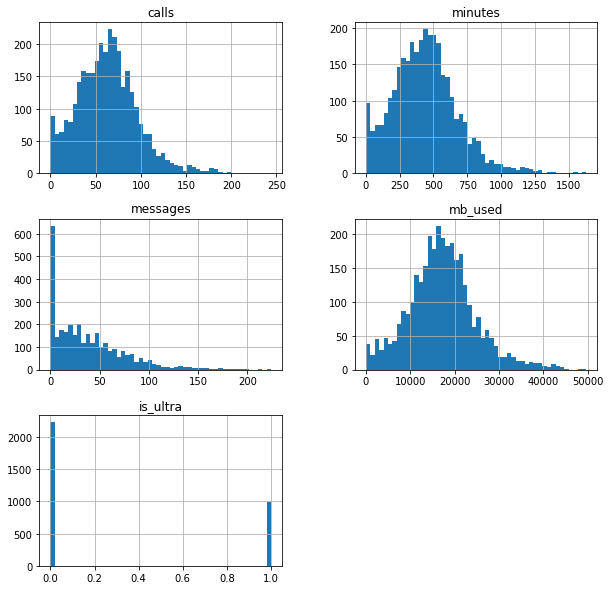

In [4]:
data.hist(figsize=(10, 10), bins=50);

**Приведем типы данных столбцов 'calls' и 'messages' в int.**

In [5]:
data['calls'] = data['calls'].astype('int')
data['messages'] = data['messages'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


**Выведена общая информация о данных датафрейма, приведены типы данных столбцов 'calls' и 'messages' в int.**

**Построим парные корреляции для всех параметров датафрейма**

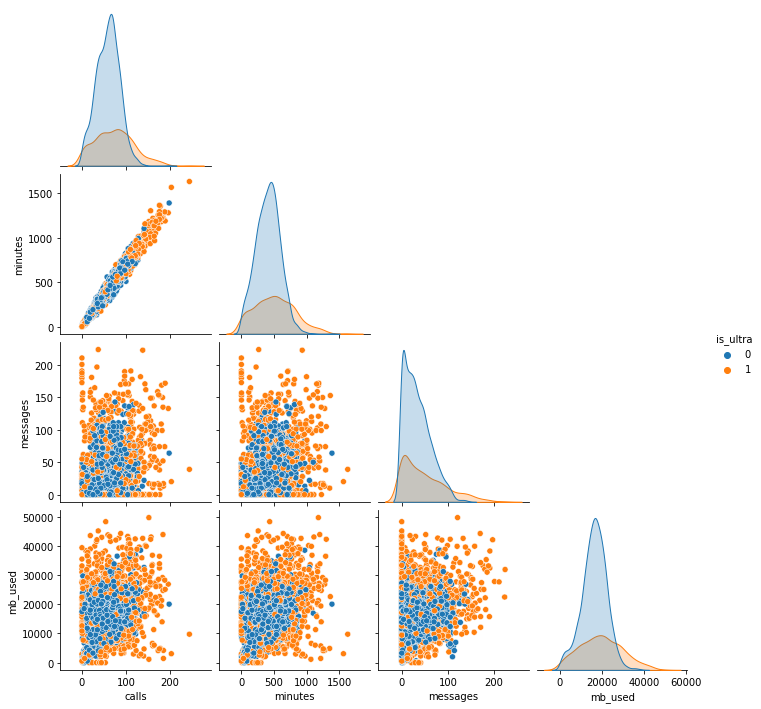

In [9]:
sns.pairplot(data, hue='is_ultra', corner=True);

In [10]:
data['minutes'].corr(data['calls']).round(2)

0.98

**Отмечается явная прямая линейная зависимость между суммарной длительностью звонков 'minutes' и количеством звонков 'calls' (коэффициент корреляции 0,98). При этом длительность и количество звонков у клиентов с тарифом "Ультра", в основном, больше чем эти параметры у клиентов с тарифом "Смарт".**

## Разбейте данные на выборки

**Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении 60/20/20 %.**

In [6]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

In [7]:
features_train, features_test, target_train, target_test  = \
train_test_split(features, target, test_size=0.4, random_state=12345)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1928, 4)
(1928,)
(1286, 4)
(1286,)


In [8]:
features_valid, features_test, target_valid, target_test  = \
train_test_split(features_test, target_test, test_size=0.5, random_state=12345)

In [9]:
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(643, 4)
(643,)
(643, 4)
(643,)


**Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 60/20/20 %.**

## Исследуйте модели

**3.1. Исследуем модель "Решающее дерево" (DecisionTreeClassifier).**

In [10]:
best_model_tree = None
best_depth_tree = 0
best_result_tree = 0
for depth in range(1, 11):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    result_tree = accuracy_score(target_valid, predictions_valid_tree)
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_result_tree = result_tree
        
print("Глубина 'Max_depth' лучшей модели:", best_depth_tree)
print("Правильность 'Accuracy' лучшей модели:", best_result_tree)

Глубина 'Max_depth' лучшей модели: 3
Правильность 'Accuracy' лучшей модели: 0.7853810264385692


**3.2. Исследуем модель "Случайный лес" (RandomForestClassifier).**

In [11]:
best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_result_forest = 0
for est in range(1, 11):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        result_forest = model_forest.score(features_valid, target_valid)
        if result_forest > best_result_forest:
            best_model_forest = model_forest
            best_est_forest = est
            best_depth_forest = depth
            best_result_forest = result_forest

print("Количество деревьев 'Estimators' лучшей модели:", best_depth_forest,)
print("Глубина 'Max_depth' лучшей модели:", best_depth_forest)
print("Правильность 'Accuracy' лучшей модели:", best_result_forest)

Количество деревьев 'Estimators' лучшей модели: 8
Глубина 'Max_depth' лучшей модели: 8
Правильность 'Accuracy' лучшей модели: 0.80248833592535


**3.3. Исследуем модель "Логическая регрессия" (LogisticRegression).**

In [12]:
model_logistic = LogisticRegression(random_state=12345) 
model_logistic.fit(features_train, target_train) 
predictions_valid_logistic = model_logistic.predict(features_valid)
accuracy_logistic = accuracy_score(target_valid, predictions_valid_logistic)

print("Правильность 'Accuracy':", accuracy_logistic)

Правильность 'Accuracy': 0.7107309486780715


**Исследование моделей**
- Модель "Решающее дерево" (DecisionTreeClassifier): глубина 'Max_depth' лучшей модели: 3, правильность 'Accuracy' лучшей модели: 0.7853810264385692.
- Модель "Случайный лес" (RandomForestClassifier): количество деревьев 'Estimators' лучшей модели: 8, глубина 'Max_depth' лучшей модели: 8, правильность 'Accuracy' лучшей модели: 0.80248833592535.
- Модель "Логическая регрессия" (LogisticRegression): правильность 'Accuracy': 0.7107309486780715.

**Наибольшая правильность 'Accuracy' у модели "Случайный лес", которая составила 0.8**

## Проверьте модель на тестовой выборке

In [13]:
result_test_tree = best_model_tree.score(features_test, target_test)
print("Правильность 'Accuracy' модели Решающее дерево (DecisionTreeClassifier):", result_test_tree)

Правильность 'Accuracy' модели Решающее дерево (DecisionTreeClassifier): 0.7791601866251944


In [14]:
result_test_forest = best_model_forest.score(features_test, target_test)
print("Правильность 'Accuracy' модели Случайный лес (RandomForestClassifier):", result_test_forest)

Правильность 'Accuracy' модели Случайный лес (RandomForestClassifier): 0.7962674961119751


In [15]:
result_test_logistic = model_logistic.score(features_test, target_test)
print("Правильность 'Accuracy' модели Логическая регрессия (LogisticRegression):", result_test_logistic)

Правильность 'Accuracy' модели Логическая регрессия (LogisticRegression): 0.6842923794712286


**Проведена проверка моделей на тестовой выборке**
- Наилучшая модель "Случайный лес" (RandomForestClassifier), у которой Правильность 'Accuracy' составила почти 0.8.

## Проверка модели на адекватность

In [16]:
model_dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dummy.fit(features_train, target_train)
result_dummy = model_dummy.score(features_valid, target_valid)
print("Правильность 'Accuracy' DummyClassifier:", result_dummy)
print("Правильность 'Accuracy' модели Случайный лес (RandomForestClassifier):", result_test_forest)

Правильность 'Accuracy' DummyClassifier: 0.7060653188180405
Правильность 'Accuracy' модели Случайный лес (RandomForestClassifier): 0.7962674961119751


**Правильность модели Случайный лес больше правильности DummyClassifier, поэтому модель адекватна.**

## Общий вывод

**Вывод общей информации о датафрейме**
- Выведена общая информация о данных датафрейма, приведены типы данных столбцов 'calls' и 'messages' в int.
- Отмечается явная прямая линейная зависимость между суммарной длительностью звонков 'minutes' и количеством звонков 'calls' (коэффициент корреляции 0,98). При этом длительность и количество звонков у клиентов с тарифом "Ультра", в основном, больше чем эти параметры у клиентов с тарифом "Смарт".
- Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 60/20/20 %.

**Исследованы модели**
- Модель "Решающее дерево" (DecisionTreeClassifier): глубина 'Max_depth' лучшей модели: 3, правильность 'Accuracy' лучшей модели: 0.7853810264385692.
- Модель "Случайный лес" (RandomForestClassifier): количество деревьев 'Estimators' лучшей модели: 8, глубина 'Max_depth' лучшей модели: 8, правильность 'Accuracy' лучшей модели: 0.80248833592535.
- Модель "Логическая регрессия" (LogisticRegression): правильность 'Accuracy': 0.7107309486780715.

**Наибольшая правильность 'Accuracy' у модели "Случайный лес", которая составила 0.8**

**Проведена проверка моделей на тестовой выборке**
- Наилучшая модель "Случайный лес" (RandomForestClassifier), у которой Правильность 'Accuracy' составила почти 0.8.

**Правильность модели Случайный лес больше правильности DummyClassifier, поэтому модель адекватна.**